In [2]:
import numpy as np
import pandas as pd

#Visualisation Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from pandas.plotting import scatter_matrix

import scikitplot as skplt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.utils import resample
#Training and Preprocessing Libraries
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score, auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
df1 = pd.read_csv('Accident_Information.csv')

In [4]:
df2 = pd.read_csv('Vehicle_Information.csv', encoding = 'latin')

In [5]:
def handle_point_of_impact(df):
    df = df[df['X1st_Point_of_Impact']!= 'Data missing or out of range'] 
    encoding = {
        'X1st_Point_of_Impact':
        {
            'Front': 1,
            'Back': 2, 
            'Offside': 3,
            'Nearside': 4,
            'Did not impact':5
        }
    }
    df.replace(encoding, inplace = True)
    return df

In [6]:
df2 = handle_point_of_impact(df2)

In [7]:
df2 = df2[df2['Vehicle_Type'] != 'Data missing or out of range']
df2 = df2[~df2['Vehicle_Type'].isna()]

In [8]:
le = LabelEncoder()
df2['Vehicle_Type'] = le.fit_transform(df2['Vehicle_Type'])

In [9]:
def handle_casualities(num_cas):
    if num_cas >=1 and num_cas <2:
        return 1
    elif num_cas >=2 and num_cas <3:
        return 2
    elif num_cas >=3 and num_cas <4:
        return 3
    elif num_cas >= 4 and num_cas <5:
        return 4
    elif num_cas >= 5:
        return 5

In [10]:
df1['Number_of_Casualties'] = df1['Number_of_Casualties'].apply(handle_casualities)

In [11]:
df1 = df1[['Accident_Index',
    'Carriageway_Hazards',
             'Light_Conditions', 
             'Day_of_Week', 
             'Number_of_Casualties',
             'Number_of_Vehicles',
             'Special_Conditions_at_Site',
             '1st_Road_Class', 
             'Junction_Detail',
             'Road_Surface_Conditions',
             'Urban_or_Rural_Area', 'Road_Type', 
             'Weather_Conditions', 'Speed_limit', 
             'Time','Accident_Severity']]

In [12]:
df2 = df2[['Accident_Index','Engine_Capacity_.CC.',
           'Age_Band_of_Driver', 'Sex_of_Driver',
          'X1st_Point_of_Impact','Vehicle_Type' ]]

In [13]:
def handle_age_of_driver(df):
    df['Age_Band_of_Driver'] = df['Age_Band_of_Driver'].replace(['Data missing or out of range'],'26 - 35')
    df = df[df['Age_Band_of_Driver'] != '0 - 5' ]
    df = df[df['Age_Band_of_Driver'] != '6 - 10' ]
    encoding = {
        'Age_Band_of_Driver':{
        '26 - 35': 1,
        '36 - 45': 2,
        '46 - 55': 3,
        '21 - 25': 4,
        '56 - 65': 5,
        '16 - 20': 6,
        '66 - 75': 7,
        'Over 75': 8,
        '11 - 15': 9}  
    }
    df.replace(encoding, inplace = True)
    return df

In [14]:
from sklearn.preprocessing import Imputer
imp=Imputer(missing_values="NaN", strategy="mean" )
imp.fit(df2[["Engine_Capacity_.CC."]])
df2["Engine_Capacity_.CC."]=imp.transform(df2[["Engine_Capacity_.CC."]]).ravel()

In [15]:
df2["Engine_Capacity_.CC."].describe()

count    2.174092e+06
mean     2.042165e+03
std      1.827526e+03
min      1.000000e+00
25%      1.360000e+03
50%      1.796000e+03
75%      2.042165e+03
max      9.600000e+04
Name: Engine_Capacity_.CC., dtype: float64

In [16]:
df2 = df2[df2["Engine_Capacity_.CC."] < 40000]

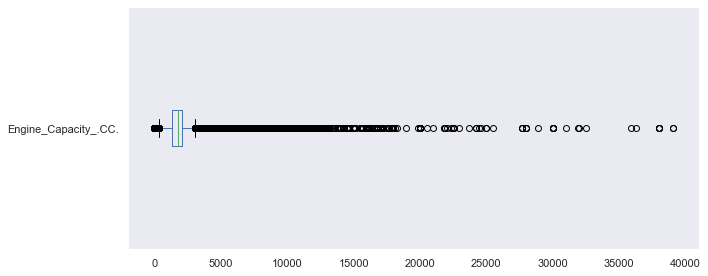

In [17]:
import seaborn as sns
sns.set(style='darkgrid')
fig, ax = plt.subplots(1,1, figsize=(10,4))
df2.boxplot(column=['Engine_Capacity_.CC.'], grid=False, vert=False, ax=ax)
plt.tight_layout();

In [18]:
df2['Engine_Capacity_.CC.'] = pd.qcut(df2['Engine_Capacity_.CC.'], 30, labels = False, duplicates = 'drop')

In [19]:
df2['Sex_of_Driver'].value_counts()

Male                            1466210
Female                           632425
Not known                         75333
Data missing or out of range         61
Name: Sex_of_Driver, dtype: int64

In [20]:
def handle_sex_of_driver(df):
    df = df[df['Sex_of_Driver'] != 'Data missing or out of range']
    df['Sex_of_Driver'] = df['Sex_of_Driver'].replace(['Not known'], 'Male')
    encoding = {
        'Sex_of_Driver':{
            'Male': 1,
            'Female': 2
        }  
    }
    df.replace(encoding, inplace = True)
    return df

In [21]:
df2 = handle_age_of_driver(df2)
df2 = handle_sex_of_driver(df2)

In [22]:
df = pd.merge(df1, df2, how = 'inner', on = 'Accident_Index')

In [23]:
df.drop('Accident_Index', axis=1, inplace = True)

In [24]:
def handle_Road_Type(df):
    df = df[df['Road_Type'] != 'Unknown']
    encoding = {
    "Road_Type": 
        {"Single carriageway": 1,
         "Dual carriageway": 2,
         "Roundabout": 3, 
         "One way street": 4,
         "Slip road": 5}
    }
    df.replace(encoding, inplace=True)
    return df

def handle_Carriageway_Hazards(df):
    df  = df[df['Carriageway_Hazards'] != 'Data missing or out of range']
    encoding = {
"Carriageway_Hazards": {"None": 0,
                        "Other object on road": 1, 
                        "Any animal in carriageway (except ridden horse)": 1, 
                        "Pedestrian in carriageway - not injured": 1, 
                        "Previous accident": 1, 
                        "Vehicle load on road": 1}
}
    df.replace(encoding, inplace=True)
    return df

def handle_Light_Condition(df):
    #deal with column 'Light_Conditions', filter missing data and  unknown lighting
    df = df[df['Light_Conditions'] != 'Data missing or out of range']
    df = df[df['Light_Conditions'] != 'Darkness - lighting unknown']
    encoding = {
        "Light_Conditions": {"Daylight": 0, 
                             "Darkness - lights lit": 1, 
                             "Darkness - no lighting": 2, 
                             "Darkness - lights unlit": 2}
    }
    df.replace(encoding, inplace=True)
    return df

def handle_day_of_week(df):  
    encoding= {
        "Day_of_Week": {"Monday": 0, 
                        "Tuesday": 0, 
                        "Wednesday": 0, 
                        "Thursday": 0, 
                        "Friday": 1,
                        "Saturday": 2, 
                        "Sunday": 2}
    }
    df.replace(encoding, inplace=True)
    return df

def handle_Special_Conditions_at_Site(df):
    df  = df[df['Special_Conditions_at_Site'] != 'Data missing or out of range']
    encoding = {
    "Special_Conditions_at_Site": 
                {"None": 0, 
                 "Roadworks": 1, 
                 "Oil or diesel": 2, 
                 "Mud": 3, 
                 "Road surface defective": 4, 
                 "Auto traffic signal - out": 5, 
                 "Road sign or marking defective or obscured": 6, 
                 "Auto signal part defective": 7}
    }
    df.replace(encoding, inplace=True)
    return df

def handle_1st_Road_Class(df):
    encoding = {
        "1st_Road_Class": {"A": 1, 
                           "A(M)": 1, 
                           "B": 2, 
                           "C": 3, 
                           "Motorway": 4, 
                           "Unclassified": 5}
    }
    df.replace(encoding, inplace=True)
    return df


def handle_Junction_Detail(df):
    df  = df[df['Junction_Detail'] != 'Data missing or out of range']
    encoding = {
    "Junction_Detail": 
                {"Not at junction or within 20 metres": 1,
                 "T or staggered junction": 2,
                 "Crossroads": 3, 
                 "Roundabout": 4,
                 "Private drive or entrance": 5,
                 "Other junction": 6,
                 "Slip road": 7,
                 "More than 4 arms (not roundabout)": 8,
                 "Mini-roundabout": 9}
    }
    df.replace(encoding, inplace=True)
    return df

def handle_Road_Surface_Type(df):
    df  = df[df["Road_Surface_Conditions"] != 'Data missing or out of range']
    encoding = {
    "Road_Surface_Conditions": 
                    {"Dry": 1,
                     "Wet or damp": 2,
                     "Frost or ice": 3, 
                     "Snow": 4,
                     "Flood over 3cm. deep": 5}
    }
    df.replace(encoding, inplace=True)
    return df

def handle_Urban_or_Rural(df):
    df = df[df['Urban_or_Rural_Area'] != 'Unallocated']
    encoding = {
    "Urban_or_Rural_Area": 
                {"Urban": 1,
                 "Rural": 2}
    }
    df.replace(encoding, inplace=True)
    return df

def handle_Weather_Conditions(df):
    df = df[df['Weather_Conditions'] != 'Data missing or out of range']
    df['Weather_Conditions'] = df['Weather_Conditions'].replace(['Unknown'], 'Fine no high winds')
    encoding = {
    "Weather_Conditions": 
                {"Fine no high winds": 1,
                 "Raining no high winds": 2,
                 "Raining + high winds": 3,
                 "Fine + high winds": 4,
                 "Snowing no high winds": 5,
                 "Fog or mist": 6,
                 "Snowing + high winds": 7,
                 "Other": 8 }
    }
    df.replace(encoding, inplace=True)
    return df

def handle_Speed_Limit(df):
    df = df[df['Speed_limit'] != 0.0]
    df.dropna(subset = ['Speed_limit'], inplace = True)
    return df

def time_to_period(hour):
    if hour >= 6 and hour < 10:
        return 1
    elif hour >= 10 and hour < 12:
        return 2
    elif hour >= 12 and hour < 14:
        return 3
    elif hour >= 14 or hour < 16:
        return 4
    elif 16 <= hour < 18:
        return 5
    elif 18 <= hour < 22:
        return 6
    else:
        return 7

def handle_Time(df):
    df.dropna(subset = ['Time'],inplace = True)
    df['Hour'] = df['Time'].str[0:2]
    df['Hour'] = pd.to_numeric(df['Hour'])
    df['Hour'] = df['Hour'].astype('int')
    df['Period'] = df['Hour'].apply(time_to_period)
    df.drop(columns = ['Hour','Time'], inplace = True)
    return df

def handle_Label(df):
    #convert 'Fatal' label to 'Serious'
    df['Accident_Severity'] = df['Accident_Severity'].replace(['Fatal'], 'Serious')
    df['Accident_Severity'] = df['Accident_Severity'].replace(['Serious'], 1)
    df['Accident_Severity'] = df['Accident_Severity'].replace(['Slight'], 0)
    return df

In [25]:
def preprocess(df):
    #choose the columns we want to use for our prediction model
#     df = df[['Carriageway_Hazards',
#              'Light_Conditions', 
#              'Day_of_Week', 
#              'Special_Conditions_at_Site',
#              '1st_Road_Class', 'Junction_Detail',
#              'Road_Surface_Conditions',
#              'Urban_or_Rural_Area', 'Road_Type', 
#              'Weather_Conditions', 'Speed_limit', 
#              'Time','Accident_Severity', 
#              'Engine_Capacity_.CC.', 'Age_Band_of_Driver',
#        'Sex_of_Driver']]
    df = handle_Carriageway_Hazards(df)
    df = handle_Light_Condition(df)
    df = handle_day_of_week(df)
    df = handle_Special_Conditions_at_Site(df)
    df = handle_1st_Road_Class(df)
    df = handle_Junction_Detail(df)
    df = handle_Road_Surface_Type(df)
    df = handle_Road_Type(df)
    df = handle_Urban_or_Rural(df)
    df = handle_Weather_Conditions(df)
    df = handle_Speed_Limit(df)
    df = handle_Time(df)
    df = handle_Label(df)
    return df

In [26]:
df = preprocess(df)

In [27]:
def get_test_data(df):
    df, df_test = train_test_split(df, test_size = 0.1)
    return df, df_test

In [28]:
def get_Xy(df):
    
    y = df[['Accident_Severity']]
    X = df.drop('Accident_Severity',axis = 1)
    return X, y

In [29]:
def downsample(df):
    
    df_majority = df[df.Accident_Severity == 0]
    df_minority = df[df.Accident_Severity == 1]
    
    df_majority_downsampled = resample(df_majority,
                                  replace = False,
                                  n_samples = len(df_minority),
                                  random_state = 40)

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    return df_downsampled

In [30]:
def get_smaller_subset(df_train, df_test):
    df, df_train = train_test_split(df_train, test_size = 0.1)
    df, df_test = train_test_split(df_test, test_size = 0.1)
    return df_train, df_test

In [31]:
def roc_curve1(y_test, y_prob):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [32]:
def rf_model(df_train, df_test):
    
    
    X_train, y_train = get_Xy(df_train)
    X_test, y_test = get_Xy(df_test)
    rf = RandomForestClassifier(bootstrap=True,
            criterion='gini',
            max_depth=8, 
            max_features='auto', 
            max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_impurity_split=None,
            min_samples_leaf=4, 
            min_samples_split=10,
            min_weight_fraction_leaf=0.0, 
            n_estimators=300,
            oob_score=True,
            random_state=35,
            verbose=0, warm_start=False)

    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)
    print("F1_score:",f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print('roc_auc_score:',roc_auc_score(y_test.values, y_prob[:,1]))
    feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(20).sort_values().plot(kind='barh', color='steelblue', figsize=(10,5))
    plt.xlabel('Relative Feature Importance with Random Forest');
    return y_test, y_prob, y_pred

In [33]:
def get_train_test(df):
#     df = preprocess(df)
    df, df_test = get_test_data(df)
    df_train = downsample(df)
    df_train, df_test = get_smaller_subset(df_train, df_test)
    return df_train, df_test

In [34]:
df_train, df_test = get_train_test(df)

In [45]:
tuned_parameters = {'criterion': ['gini'],
              'max_depth' : [1,5,8,10,15,20],
              'n_estimators' : [50,100,150,200,300,500,700,1000]
                   }

In [46]:
rf_model = RandomForestClassifier()
X_train, y_train = get_Xy(df_train)
rf = GridSearchCV(rf_model, tuned_parameters,cv=10)
rf.fit(X_train, y_train)
print(rf.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}


F1_score: 0.3412975912975913
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     17310
           1       0.24      0.61      0.34      2881

    accuracy                           0.66     20191
   macro avg       0.57      0.64      0.56     20191
weighted avg       0.82      0.66      0.71     20191

roc_auc_score: 0.6969383564624181


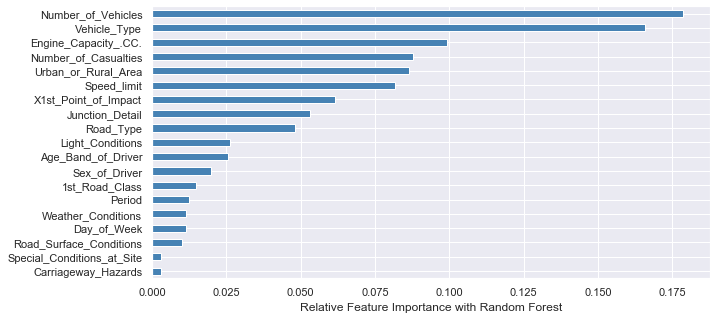

In [516]:
y_test, y_prob, y_pred = rf_model(df_train, df_test)

In [631]:
f1_score(y_test, y_pred)

0.3412975912975913

In [632]:
roc_auc_score(y_test.values, y_prob[:,1])

0.6969383564624181

In [633]:
f1 = []
f1.append(f1_score(y_test, y_pred))

In [634]:
roc_auc_dict = {}

In [635]:
roc_auc_dict = {'Random Forest' : roc_auc_score(y_test.values, y_prob[:,1])}

In [462]:
from sklearn.feature_selection import RFECV

X_train, y_train = get_Xy(df_train)
rf_1 = RandomForestClassifier(n_estimators=100,
                            random_state=35)
rfecv = RFECV(estimator=rf_1, step=1, cv=5, scoring = 'f1_macro')
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 19
Best features : Index(['Carriageway_Hazards', 'Light_Conditions', 'Day_of_Week',
       'Number_of_Casualties', 'Number_of_Vehicles',
       'Special_Conditions_at_Site', '1st_Road_Class', 'Junction_Detail',
       'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Road_Type',
       'Weather_Conditions', 'Speed_limit', 'Engine_Capacity_.CC.',
       'Age_Band_of_Driver', 'Sex_of_Driver', 'X1st_Point_of_Impact',
       'Vehicle_Type', 'Period'],
      dtype='object')


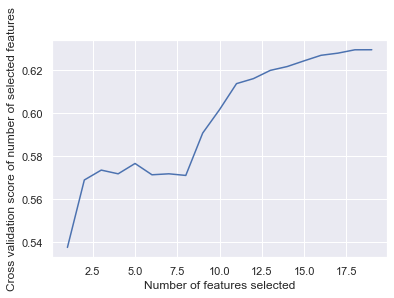

In [463]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.savefig('./1.jpg')
plt.show()

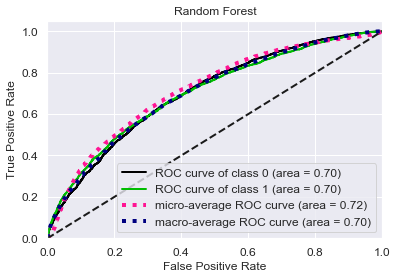

In [465]:
skplt.metrics.plot_roc_curve(y_test, y_prob)
plt.title('Random Forest')
plt.show()

In [519]:
def xgboost_model(df_train, df_test):
    X_train, y_train = get_Xy(df_train)
    X_test, y_test = get_Xy(df_test)
    classifier = EasyEnsembleClassifier(n_estimators=12, 
        base_estimator=XGBClassifier(max_depth=4, 
                        learning_rate=0.2, 
                        n_estimators=600, 
                        silent=True,
                        subsample = 0.8,
                        gamma=0.5,
                        min_child_weight=10,
                        objective='binary:logistic',
                        colsample_bytree = 0.6,
                        max_delta_step = 1,
                        nthreads=1,
                        n_jobs=-1))
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    print('roc_auc_score:',roc_auc_score(y_test.values, y_prob[:,1]))
    return y_test, y_prob, y_pred

In [520]:
y_test, y_prob1, y_pred1 = xgboost_model(df_train, df_test)

              precision    recall  f1-score   support

           0       0.92      0.67      0.78     17310
           1       0.24      0.63      0.35      2881

    accuracy                           0.67     20191
   macro avg       0.58      0.65      0.56     20191
weighted avg       0.82      0.67      0.72     20191

roc_auc_score: 0.7056548401437255


In [636]:
roc_auc_score(y_test.values, y_prob1[:,1])

0.7056548401437255

In [637]:
f1_score(y_test, y_pred1)

0.35208816705336426

In [638]:
f1.append(f1_score(y_test, y_pred1))

In [639]:
roc_auc_dict['XGboost']=  roc_auc_score(y_test.values, y_prob1[:,1])

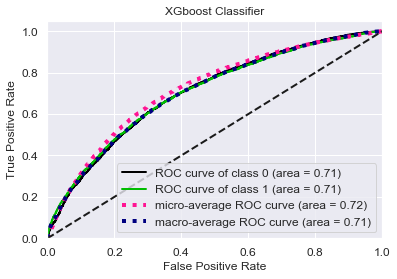

In [524]:
skplt.metrics.plot_roc_curve(y_test, y_prob1)
plt.title('XGboost Classifier')
plt.show()

In [489]:
def get_train_test1(df):
#     df = preprocess(df)
    X = df.drop('Accident_Severity', axis=1)
    y = df[['Accident_Severity']]
   
    for col in X.columns:
        X[col] = X[col].astype(str)
    X = pd.get_dummies(X)
    df = pd.concat([X,y], axis=1)
    df, df_test = get_test_data(df)
    df_train = downsample(df)
    df_train, df_test = get_smaller_subset(df_train, df_test)
    return df_train, df_test

In [656]:
df_train1, df_test1 = get_train_test1(df)

In [657]:
from sklearn.preprocessing import StandardScaler
def lr_model(df_train, df_test):
    X_train, y_train = get_Xy(df_train)
    X_test, y_test = get_Xy(df_test)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    lgr = LogisticRegression(C=1, penalty = 'l1')
    lgr.fit(X_train, y_train)
    y_pred = lgr.predict(X_test)
    y_prob = lgr.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    print('roc_auc_score:',roc_auc_score(y_test.values, y_prob[:,1]))
    return y_test, y_prob, y_pred

In [658]:
y_test, y_prob2, y_pred2 = lr_model(df_train1, df_test1)

              precision    recall  f1-score   support

           0       0.91      0.65      0.76     17248
           1       0.23      0.62      0.34      2943

    accuracy                           0.64     20191
   macro avg       0.57      0.63      0.55     20191
weighted avg       0.81      0.64      0.70     20191

roc_auc_score: 0.6918024681376582


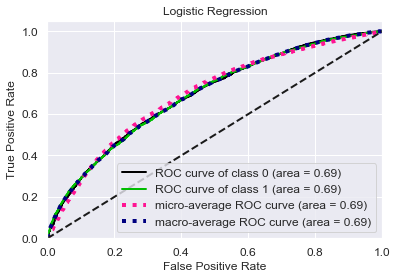

In [659]:
skplt.metrics.plot_roc_curve(y_test, y_prob2)
plt.title('Logistic Regression')
plt.show()

In [660]:
roc_auc_score(y_test, y_prob2[:,1])

0.6918024681376582

In [661]:
f1_score(y_test, y_pred2)

0.3367818215407352

In [662]:
f1.append(f1_score(y_test, y_pred2))

In [663]:
roc_auc_dict['Logistic Regression']=  roc_auc_score(y_test.values, y_prob2[:,1])

In [496]:
tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
              'penalty':['l1','l2']
                   }

In [497]:
lr_model = LogisticRegression()
lr= GridSearchCV(lr_model, tuned_parameters,cv=10)
lr.fit(X_train2, y_train1)
print(lr.best_params_)

{'C': 1, 'penalty': 'l1'}


In [198]:
lr

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [681]:
X_train, y_train = get_Xy(df_train)
X_test, y_test = get_Xy(df_test)

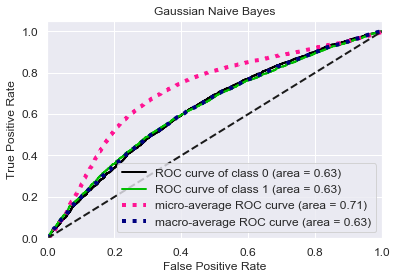

In [626]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
y_prob3 = nb.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_prob3)
plt.title('Gaussian Naive Bayes')
plt.show()

In [627]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76     17310
           1       0.14      0.30      0.19      2881

    accuracy                           0.63     20191
   macro avg       0.50      0.49      0.48     20191
weighted avg       0.75      0.63      0.68     20191



In [628]:
y_pred3 = nb.predict(X_test)

In [646]:
roc_auc_score(y_test, y_prob3[:,1])

0.6289001468013606

In [647]:
f1_score(y_test, y_pred3)

0.2986376021798365

In [543]:
y_pred3 = [int(y) for y in y_pred3]

In [644]:
f1.append(f1_score(y_test, y_pred3))

In [645]:
roc_auc_dict['GaussianNB'] = roc_auc_score(y_test.values, y_prob3[:,1])

In [587]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [589]:
y_pred_mlp = mlp.predict(X_test)

In [590]:
y_pred_mlp = [int(y) for y in y_pred_mlp]

In [591]:
print(classification_report(y_test_mlp, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81     17370
           1       0.14      0.24      0.18      2821

    accuracy                           0.69     20191
   macro avg       0.50      0.50      0.49     20191
weighted avg       0.76      0.69      0.72     20191



In [563]:
y_test_mlp['Accident_Severity'].value_counts()

0    17370
1     2821
Name: Accident_Severity, dtype: int64

In [564]:
y_test['Accident_Severity'].value_counts()

0    17310
1     2881
Name: Accident_Severity, dtype: int64

In [565]:
f1

[0.3412975912975913,
 0.35208816705336426,
 0.2075526088209859,
 0.2075526088209859,
 0.18922470433639949,
 0.3306656966169516]

In [592]:
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     17310
           1       0.28      0.45      0.34      2881

    accuracy                           0.75     20191
   macro avg       0.59      0.63      0.60     20191
weighted avg       0.81      0.75      0.78     20191



In [648]:
f1_score(y_test, y_pred_mlp)

0.34396415392725355

In [649]:
f1.append(f1_score(y_test, y_pred_mlp))

In [595]:
y_prob_mlp = mlp.predict_proba(X_test)

In [650]:
print('roc_auc_score:',roc_auc_score(y_test, y_prob_mlp[:,1]))

roc_auc_score: 0.6841751201270662


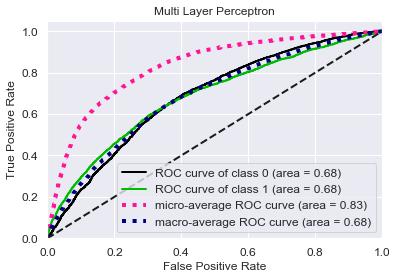

In [598]:
skplt.metrics.plot_roc_curve(y_test, y_prob_mlp)
plt.title('Multi Layer Perceptron')
plt.show()

In [651]:
roc_auc_dict['MLP'] = roc_auc_score(y_test, y_prob_mlp[:,1])

In [690]:
roc_auc_dict

{'Random Forest': 0.6969383564624181,
 'XGboost': 0.7056548401437255,
 'GaussianNB': 0.6289001468013606,
 'MLP': 0.6841751201270662,
 'AdaBoost': 0.49625538223196214,
 'Logistic Regression': 0.6918024681376582,
 'LightGBM': 0.7096053126812834}

In [558]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier( n_estimators=500, learning_rate=0.05, random_state=42)
clf.fit(X_train, y_train)
y_pred_ada = clf.predict(X_test)
y_prob_ada = clf.predict_proba(X_test)

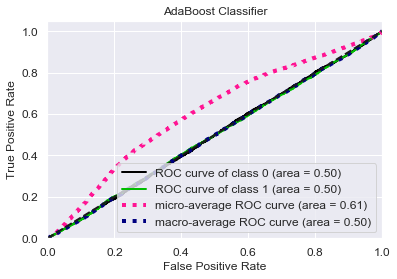

In [559]:
skplt.metrics.plot_roc_curve(y_test, y_prob_ada)
plt.title('AdaBoost Classifier')
plt.show()

In [568]:
y_pred_ada = [int(y) for y in y_pred_ada]

In [652]:
f1_score(y_test, y_pred_ada)

0.21059602649006626

In [653]:
f1.append(f1_score(y_test, y_pred_ada))

In [572]:
print(roc_auc_score(y_test.values, y_prob_ada[:,1]))
print(classification_report(y_test, y_pred_ada))

0.49625538223196214
              precision    recall  f1-score   support

           0       0.86      0.62      0.72     17310
           1       0.14      0.39      0.21      2881

    accuracy                           0.59     20191
   macro avg       0.50      0.50      0.47     20191
weighted avg       0.76      0.59      0.65     20191



In [654]:
roc_auc_dict['AdaBoost'] = roc_auc_score(y_test.values, y_prob_ada[:,1])

In [682]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(learning_rate =0.03, max_depth=40, min_data_in_leaf=10,
                   n_estimators=500, num_leaves=50, random_state = 42)
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.03, max_depth=40,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=10, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=50, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
tuned_parameters = {
    'max_depth': [5,8,10,15,20,30,40,50,70],
    'n_estimators':[100,200,300,500,1000]
}
lgbm_model = LGBMClassifier()
X_train, y_train = get_Xy(df_train)
lgbm = GridSearchCV(lgbm_model, tuned_parameters,cv=10)
lgbm.fit(X_train, y_train)
print(lgbm.best_params_)

In [683]:
y_pred_lgb = lgb.predict(X_test)
y_prob_lgb = lgb.predict_proba(X_test)

In [684]:
f1_score(y_test, y_pred_lgb)

0.3567883211678832

In [689]:
f1.append(f1_score(y_test, y_pred_lgb))

In [686]:
print(roc_auc_score(y_test, y_prob_lgb[:,1]))
print(classification_report(y_test, y_pred_ada))

0.7096053126812834
              precision    recall  f1-score   support

           0       0.86      0.62      0.72     17310
           1       0.14      0.39      0.21      2881

    accuracy                           0.59     20191
   macro avg       0.50      0.50      0.47     20191
weighted avg       0.76      0.59      0.65     20191



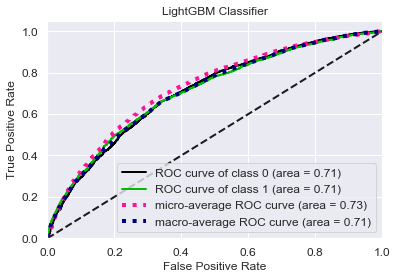

In [687]:
skplt.metrics.plot_roc_curve(y_test, y_prob_lgb)
plt.title('LightGBM Classifier')
plt.show()

In [688]:
roc_auc_dict['LightGBM'] = roc_auc_score(y_test, y_prob_lgb[:,1])

In [1]:
col1 = list(roc_auc_dict.keys())
col2 = [val*100 for val in list(roc_auc_dict.values())]
result = pd.DataFrame.from_dict({'Classifier':col1, 'ROC_AUC':col2, 'F1_score': f1})
fig, ax =plt.subplots(nrows=2, ncols=1, figsize = (11,9))
sns.barplot(x='ROC_AUC', y='Classifier', data=result, palette='plasma', ax=ax[0])
sns.barplot(x='F1_score', y='Classifier', data=result, palette='plasma', ax=ax[1])

NameError: name 'roc_auc_dict' is not defined